In [ ]:
import rioxarray
import os
import glob

# 打印指定路径下的所有数据结构
data_path = r'D:\xarray\pre-process'

# 列出目录中的所有文件和文件夹
print("Files and directories in", data_path, ":")
for item in os.listdir(data_path):
    item_path = os.path.join(data_path, item)
    if os.path.isdir(item_path):
        print(f"Directory: {item}")
    else:
        print(f"File: {item}")

# 列出所有GeoTIFF文件
geotiff_files = glob.glob(os.path.join(data_path, "*.tif"))
print("\nGeoTIFF files found:")
for file in geotiff_files:
    print(f"- {os.path.basename(file)}")

# 如果有GeoTIFF文件，加载第一个并显示其结构
if geotiff_files:
    print("\nLoading first GeoTIFF file for structure analysis...")
    da = rioxarray.open_rasterio(geotiff_files[0])
    
    # 打印概览
    print("\nData overview:")
    print(da)
    
    # 查看维度、坐标
    print("\nDimensions:", da.dims)
    print("Coordinates:", da.coords)
    
    # 查看元数据
    print("\nMetadata:")
    print("CRS:", da.rio.crs)
    print("Transform:", da.rio.transform())
    print("NoData value:", da.rio.nodata)
    print("Attributes:", da.attrs)
else:
    print("\nNo GeoTIFF files found in the directory.")


In [ ]:
import xarray as xr
ds=xr.open_dataset(r'D:\xarray\final_mask_1km_new.nc')

population=xr.open_dataset(r'D:\xarray\population_density_simple.nc')

ds['final_mask'].values[0,0]



In [ ]:
lat_resolution=ds.lat.values[1]-ds.lat.values[0]
lon_resolution=ds.lon.values[1]-ds.lon.values[0]
print(lat_resolution,lon_resolution)

p_lat_resolution=population.lat.values[1]-population.lat.values[0]
p_lon_resolution=population.lon.values[1]-population.lon.values[0]
print(p_lat_resolution,p_lon_resolution)





In [ ]:
# Plot the result with coarsening to improve visualization
import matplotlib.pyplot as plt

# Define coarsening factor
coarsen_factor = 5  # Adjust this value based on your data resolution

# Coarsen the data for better visualization
pop_coarse = population['pop_density_2020'].coarsen(lat=coarsen_factor, lon=coarsen_factor).mean()
mask_coarse = ds['final_mask'].coarsen(lat=coarsen_factor, lon=coarsen_factor).mean()

# Create a vertical layout (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Plot coarsened population density
pop_map = pop_coarse.plot(ax=axes[0], cmap='viridis')
axes[0].set_title('Population Density 2020 (Coarsened)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(pop_map, ax=axes[0], label='Population Density')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot coarsened final mask
mask_map = mask_coarse.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Final Mask (Coarsened)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(mask_map, ax=axes[1], label='Mask Value')
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the valid data in 'ds'
import numpy as np

valid_count = (~np.isnan(ds['final_mask'])).sum().item()
total_count = ds['final_mask'].size
valid_percentage = (valid_count / total_count) * 100

print(f"Valid data points in final_mask: {valid_count:,} out of {total_count:,} total points")
print(f"Percentage of valid data: {valid_percentage:.2f}%")


In [ ]:
import datetime as dt
from terracatalogueclient import Catalogue
from terracatalogueclient.config import CatalogueConfig, CatalogueEnvironment

# Create a link to the CLMS catalogue
config = CatalogueConfig.from_environment(CatalogueEnvironment.CGLS)
catalogue = Catalogue(config)

# Optionally list all collections (title and identifier) available in the catalogue
for c in list(catalogue.get_collections()):  
    print(f"{c.properties.get('title')} | {c.id}")

In [ ]:
import datetime as dt
import os
from tqdm import tqdm

# 你要下载的产品ID
product_id = "clms_global_gdmp_1km_v2_10daily_netcdf"

# 四季代表日期
season_days = {
    "spring": (3, 21),
    "summer": (6, 21),
    "autumn": (9, 23),
    "winter": (12, 21)
}

# 下载根目录
base_dir = r"pre-process\Gross_productivity"  # 修改为你想保存的根目录
os.makedirs(base_dir, exist_ok=True)

# 创建年份和季节的组合列表用于进度条
total_items = len(range(2000, 2023)) * len(season_days)
progress_bar = tqdm(total=total_items, desc="Downloading data")

for year in range(2000, 2023):
    for season, (month, day) in season_days.items():
        try:
            date = dt.date(year, month, day)
            products = list(catalogue.get_products(
                product_id,
                start=date,
                end=date
            ))
            if products:
                # 直接下载到base_dir并重命名
                for product in products:
                    catalogue.download_product(product, base_dir)
                    print(f"Saved")
            else:
                print(f"No products found for {year} {season}")
        except Exception as e:
            print(f"Error for {year}-{season}: {e}")
        
        progress_bar.update(1)

progress_bar.close()

# 数据预处理

一、创建master栅格用于对齐数据

操作逻辑：

1、空间范围一致：lat,lon经纬度一致
1、分辨率一致
3、坐标系一致
4、栅格对齐
5、没有栅格空洞



## 标准栅格创建与修正
不太想重新采样撂荒计算数据，把标准栅格的基座对齐到final_mask

数据输入：
    final：这是根据土地利用（撂荒）产生的mask数据
    master：这是根据美国人口统计产生的陆域bool数据

数据输出：
    r"D:\xarray\aligned\master_land_mask_on_final.nc"
    
    注：这个文件命名有点分辨不清，后期已经重命名为D:\xarray\aligned\master_land_0509.nc




In [9]:
import xarray as xr
MASTER = r"D:\xarray\master_land_mask.nc"
FINAL  = r"D:\xarray\final_mask_1km_new.nc"
master = xr.open_dataset(MASTER).land_mask          # (lat, lon)
final  = xr.open_dataset(FINAL).final_mask  

master


<xarray.DataArray 'land_mask' (lat: 21600, lon: 43200)> Size: 933MB
[933120000 values with dtype=bool]
Coordinates:
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    spatial_ref  int32 4B ...
Attributes:
    description:  True where population density is valid

In [11]:
import xarray as xr
from pathlib import Path
import numpy as np

MASTER = r"D:\xarray\master_land_mask.nc"
FINAL  = r"D:\xarray\final_mask_1km_new.nc"
OUT    = r"D:\xarray\aligned\master_land_mask_on_final.nc"

# 1) 读取
master = xr.open_dataset(MASTER).land_mask          # (lat, lon)
final  = xr.open_dataset(FINAL).final_mask          # (lat, lon 或 y,x)

# 2) 若 final 用 y/x → 改成 lat/lon（不依赖 rioxarray）
if {"x","y"}.issubset(final.dims):
    final = final.rename({"x":"lon", "y":"lat"})

# 3) 对齐：最近邻插值到 final 网格
# 将布尔类型转换为数值类型，因为interp只能处理数值类型数组
master_numeric = master.astype("uint8")  # 将布尔值转换为0和1
aligned = master_numeric.interp(
    lon=final.lon, lat=final.lat, method="nearest"
).astype("uint8")

# 4) 保留 0/1，写 NetCDF
aligned.to_dataset(name="land_mask").to_netcdf(
    OUT, encoding={"land_mask":{"zlib":True,"complevel":4}}
)

print("✓ 新 land_mask 已输出:", OUT)


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


✓ 新 land_mask 已输出: D:\xarray\aligned\master_land_mask_on_final.nc


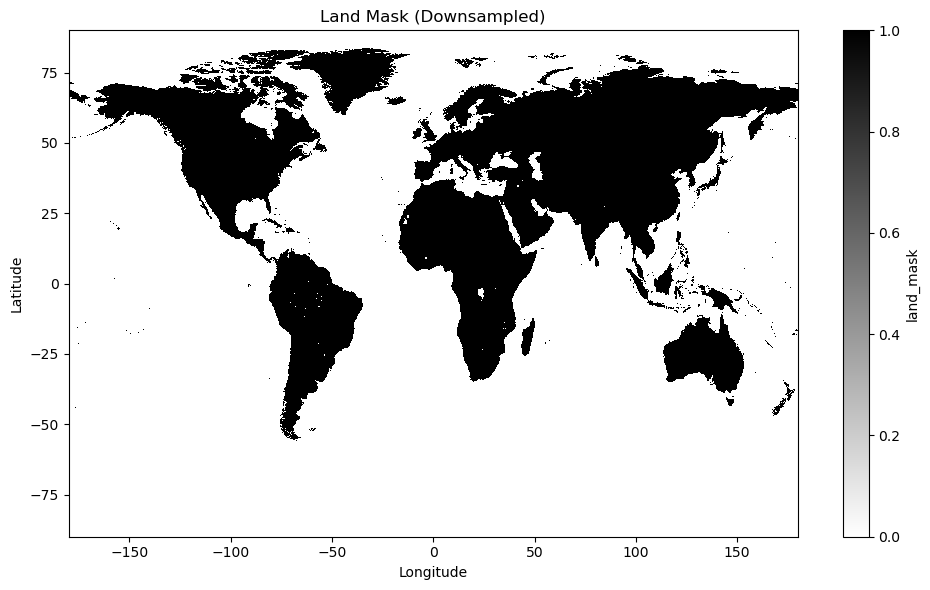

Dataset shape: (21600, 43200)
Data type: uint8


In [15]:
newmaster_path = r'D:\xarray\aligned\master_land_0509.nc'

newmaster = xr.open_dataset(newmaster_path)

import matplotlib.pyplot as plt

# The dataset is too large to plot directly, so we'll downsample it
# Downsample the data to avoid memory error
n = 10  # Adjust this value based on your memory constraints
downsampled = newmaster.land_mask.isel(lat=slice(None, None, n), lon=slice(None, None, n))

# Create a simple figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the downsampled data with simple colors
downsampled.plot(ax=ax, cmap='binary', add_colorbar=True)

# Add basic title and labels
plt.title('Land Mask (Downsampled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Display basic information about the dataset
print(f"Dataset shape: {newmaster.land_mask.shape}")
print(f"Data type: {newmaster.land_mask.dtype}")


### 标准栅格检查结果（没问题）
分辨率比较:
newmaster 经度分辨率: 0.008333333333325754 度
newmaster 纬度分辨率: 0.008333333333354176 度
final_mask 经度分辨率: 0.008333333333325754 度
final_mask 纬度分辨率: 0.008333333333354176 度
分辨率比例 (newmaster/final_mask) - 经度: 1.00x
分辨率比例 (newmaster/final_mask) - 纬度: 1.00x

数据集形状:
newmaster: FrozenMappingWarningOnValuesAccess({'lon': 43200, 'lat': 21600})
final_mask variables: ['final_mask']
final_mask land_mask shape: (21600, 43200)

### 标准栅格修正



## 气候TIFF预处理

Number of bands: 1
Raster shape: (20880, 43200)
Raster data type: uint16
Bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888885002, right=179.99985967115003, top=83.99986041514998)
CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223600004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


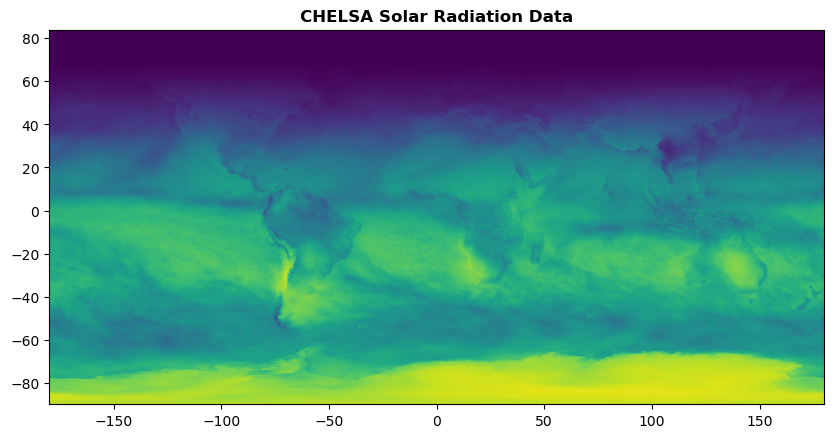

<Figure size 640x480 with 0 Axes>

In [21]:
raster_path = r'D:\xarray\pre-process\Climate\CHELSA_rsds_2000_01_V.2.1.tif'

# 读取tif文件
import rasterio
from rasterio.plot import show

# 打开tif文件
with rasterio.open(raster_path) as src:
    # 显示波段数量
    print(f"Number of bands: {src.count}")
    
    # 读取数据
    raster_data = src.read(1)  # 读取第一个波段
    
    # 显示基本信息
    print(f"Raster shape: {raster_data.shape}")
    print(f"Raster data type: {raster_data.dtype}")
    print(f"Bounds: {src.bounds}")
    print(f"CRS: {src.crs}")
    
    # 可视化
    plt.figure(figsize=(10, 6))
    show(src, title="CHELSA Solar Radiation Data")
    plt.tight_layout()
    plt.show()


### 气候预处理小样本

    根据以上元数据信息，发现坐标、经纬度、分辨率多少都有点不一样。
    

In [43]:
# align_to_master_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np

# ── 配置 ─────────────────────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_PATH = r"D:\xarray\pre-process\Climate\CHELSA_rsds_2000_01_V.2.1.tif"
OUT_DIR  = Path(r"D:\xarray\aligned"); OUT_DIR.mkdir(exist_ok=True)
OUT_PATH = OUT_DIR / f"{Path(SRC_PATH).stem}.nc"

# ── 1. 读取模板掩膜与坐标 ───────────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat = tmpl["lat"]              # 长度 21600
lon = tmpl["lon"]              # 长度 43200
mask = tmpl["land_mask"]       # 布尔掩膜

# ── 2. 读取源栅格，仅懒加载，不切初块 ─────────
da = (rxr.open_rasterio(SRC_PATH, masked=True)
        .squeeze("band", drop=True)
        .rio.set_spatial_dims("x", "y", inplace=False)
        .rename({"x": "lon", "y": "lat"}))

# ── 3. 插值对齐到模板格网 ───────────────
# “nearest” 保证分类/掩膜无误；若连续量用 method="linear"
da_aligned = da.interp(lon=lon, lat=lat, method="nearest")

# ── 4. 应用模板掩膜 ────────────────────
da_masked = da_aligned.where(mask)

# ── 5. 计算合法 chunks 大小 ─────────────
# 模板维度 21600 和 43200，选一个能整除的块数，如 40×80→块大小 540×540
chunk_lat = len(lat) // 40   # = 21600/40 = 540
chunk_lon = len(lon) // 80   # = 43200/80 = 540

# ── 6. 分块 & 写 NetCDF ───────────────
var = da_masked.name or "var"
ds_out = da_masked.chunk({"lat": chunk_lat, "lon": chunk_lon})\
                  .to_dataset(name=var)

encoding = {
    var: {
        "zlib": True,
        "complevel": 5,
        "chunksizes": (chunk_lat, chunk_lon)
    }
}

ds_out.to_netcdf(OUT_PATH, encoding=encoding)
print("✓ 输出成功：", OUT_PATH)


✓ 输出成功： D:\xarray\aligned\CHELSA_rsds_2000_01_V.2.1.nc


### 气候预处理样本检查

初步检查校准的文件是否正确，这里检查步骤分为两个
1、检查经度、维度分辨率是否与撂荒特征数据一致；
2、以master为标准校正后的数据，能否与撂荒数据进行逻辑运算操作。

校验输出：
    file1 = r"D:\xarray\aligned\CHELSA_rsds_2000_01_V.2.1.nc"
    file2 = r"D:\xarray\final_mask_1km_new.nc"

经度分辨率: 0.008333333333325754度
纬度分辨率: 0.008333333333354176度


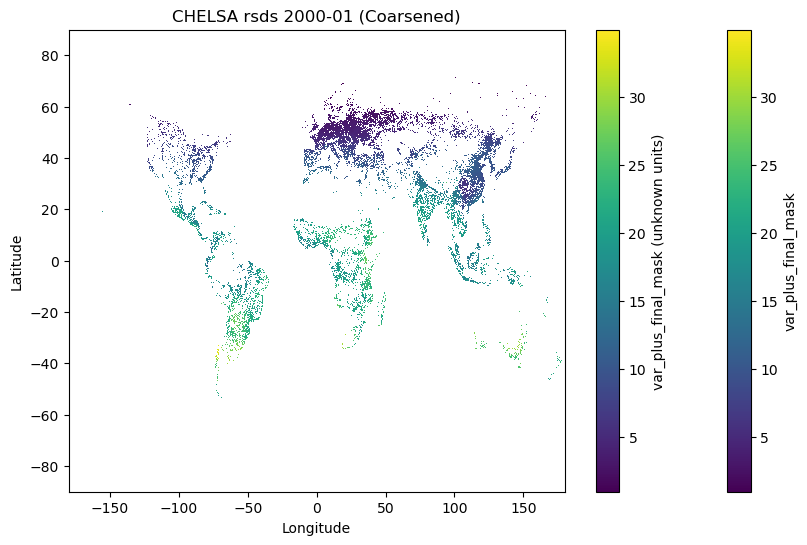


数据基本信息:
<xarray.Dataset> Size: 4GB
Dimensions:              (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref          int32 4B ...
  * lon                  (lon) float64 346kB -180.0 -180.0 ... 180.0 180.0
  * lat                  (lat) float64 173kB 90.0 89.99 89.98 ... -89.99 -90.0
    time                 datetime64[ns] 8B ...
Data variables:
    var_plus_final_mask  (lat, lon) float32 4GB nan nan nan nan ... nan nan nan


In [2]:
# 读取并可视化对齐后的气候数据
import matplotlib.pyplot as plt
import xarray as xr

# 读取NetCDF文件
file_path = r"D:\xarray\aligned\test_sum.nc"
ds = xr.open_dataset(file_path)

# 获取主要变量
var_name = list(ds.data_vars)[0]
data = ds[var_name]

# 计算并打印经度和纬度的分辨率
lon_res = abs(data.lon[1].values - data.lon[0].values)
lat_res = abs(data.lat[1].values - data.lat[0].values)
print(f"经度分辨率: {lon_res:}度")
print(f"纬度分辨率: {lat_res:}度")

# 使用coarse方法进行可视化（降低分辨率以加快绘图）
coarse_data = data.coarsen(lon=10, lat=10).mean()

# 创建可视化图
fig, ax = plt.subplots(figsize=(10, 6))
# 使用imshow或pcolormesh并保存返回的mappable对象
im = coarse_data.plot(ax=ax, cmap='viridis')
plt.title(f'CHELSA rsds 2000-01 (Coarsened)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# 使用已创建的mappable对象添加colorbar
plt.colorbar(im, label=f'{var_name} ({getattr(data, "units", "unknown units")})')
plt.show()

# 显示数据基本信息
print("\n数据基本信息:")
print(ds)

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm

def add_climate_files(file1_path, file2_path, output_path):
    """
    对两个气候数据文件进行加法操作
    
    Parameters:
    -----------
    file1_path : str
        第一个输入文件路径
    file2_path : str
        第二个输入文件路径
    output_path : str
        输出文件路径
    """
    # 设置chunk大小
    chunk_size = 500
    
    # 打开数据集，使用chunking
    with xr.open_dataset(file1_path, chunks={'lat': chunk_size, 'lon': chunk_size}) as ds1, \
         xr.open_dataset(file2_path, chunks={'lat': chunk_size, 'lon': chunk_size}) as ds2:
        
        # 获取变量名
        var1 = list(ds1.data_vars)[0]
        var2 = list(ds2.data_vars)[0]
        
        # 确保两个数据集具有相同的维度
        if not (ds1[var1].dims == ds2[var2].dims):
            raise ValueError("两个数据集必须具有相同的维度")
        
        # 执行加法操作
        result = ds1[var1] + ds2[var2]
        
        # 创建新的数据集
        ds_out = result.to_dataset(name=f"{var1}_plus_{var2}")
        
        # 设置编码
        encoding = {list(ds_out.data_vars)[0]: {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_size, chunk_size)
        }}
        
        # 保存结果
        ds_out.to_netcdf(output_path, encoding=encoding)
        
        return output_path

def main():
    # 设置文件路径
    file1 = r"D:\xarray\aligned\CHELSA_rsds_2000_01_V.2.1.nc"
    file2 = r"D:\xarray\final_mask_1km_new.nc"
    output = r"D:\xarray\aligned\test_sum.nc"
    
    try:
        # 执行加法操作
        result_path = add_climate_files(file1, file2, output)
        print(f"✓ 加法操作完成，结果保存至: {result_path}")
        
        # 验证结果
        with xr.open_dataset(result_path) as ds:
            print("\n结果数据集信息:")
            print(ds)
            
    except Exception as e:
        print(f"× 处理过程中出错: {str(e)}")

if __name__ == "__main__":
    main()

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


✓ 加法操作完成，结果保存至: D:\xarray\aligned\test_sum.nc

结果数据集信息:
<xarray.Dataset> Size: 4GB
Dimensions:              (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref          int32 4B ...
  * lon                  (lon) float64 346kB -180.0 -180.0 ... 180.0 180.0
  * lat                  (lat) float64 173kB 90.0 89.99 89.98 ... -89.99 -90.0
    time                 datetime64[ns] 8B ...
Data variables:
    var_plus_final_mask  (lat, lon) float32 4GB ...


### 所有气候TIFF文件推广

    数据输入：
    源目录--->D:\xarray\pre-process\Climate_rsds
    数据输出：
    目标目录--->D:\xarray\aligned\rsds

#### 短波辐射数据批处理

In [3]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_rsds")
OUT_DIR  = Path(r"D:\xarray\aligned\rsds")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
for fp in tqdm(list(SRC_DIR.glob("*.tif")), desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"

    # 2.1 读入时就分块
    da = (
        rxr.open_rasterio(fp, masked=True,
                          chunks={"x": chunk_lon, "y": chunk_lat})
          .squeeze("band", drop=True)
          .rio.set_spatial_dims("x", "y", inplace=False)
          .rename({"x": "lon", "y": "lat"})
    )

    # 2.2 按模板经纬度插值对齐（nearest 保持离散特征）
    da_al = da.interp(lon=lon, lat=lat, method="nearest")

    # 2.3 应用模板布尔掩膜
    da_masked = da_al.where(mask)

    # 2.4 构造 Dataset 并分块
    var = da_masked.name or "var"
    ds  = da_masked.to_dataset(name=var) \
                   .chunk({"lat": chunk_lat, "lon": chunk_lon})

    # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
    encoding = {
        var: {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_lat, chunk_lon)
        }
    }
    ds.to_netcdf(out_nc, encoding=encoding)

    # 2.6 关闭 & 回收
    ds.close()
    da_al = None
    da    = None
    gc.collect()

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs: 100%|██████████| 240/240 [3:28:08<00:00, 52.04s/it]  

✅ All done! Aligned files are in: D:\xarray\aligned\rsds


#### 风速批处理

理论上应该有240个文件，这里少了8个，需要核查一下。

经检查：2019年的8月...2020年12月缺失

2008-2011年可能需要重新输出一下。

In [6]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_wind")
OUT_DIR  = Path(r"D:\xarray\aligned\wind")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
for fp in tqdm(list(SRC_DIR.glob("*.tif")), desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    # 如果输出文件已经存在，跳过处理
    if out_nc.exists():
        continue

    # 2.1 读入时就分块
    da = (
        rxr.open_rasterio(fp, masked=True,
                          chunks={"x": chunk_lon, "y": chunk_lat})
          .squeeze("band", drop=True)
          .rio.set_spatial_dims("x", "y", inplace=False)
          .rename({"x": "lon", "y": "lat"})
    )

    # 2.2 按模板经纬度插值对齐（nearest 保持离散特征）
    da_al = da.interp(lon=lon, lat=lat, method="nearest")

    # 2.3 应用模板布尔掩膜
    da_masked = da_al.where(mask)

    # 2.4 构造 Dataset 并分块
    var = da_masked.name or "var"
    ds  = da_masked.to_dataset(name=var) \
                   .chunk({"lat": chunk_lat, "lon": chunk_lon})

    # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
    encoding = {
        var: {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_lat, chunk_lon)
        }
    }
    ds.to_netcdf(out_nc, encoding=encoding)

    # 2.6 关闭 & 回收
    ds.close()
    da_al = None
    da    = None
    gc.collect()

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs:   0%|          | 0/232 [00:00<?, ?it/s]

Aligning TIFs: 100%|██████████| 232/232 [1:21:39<00:00, 21.12s/it]

✅ All done! Aligned files are in: D:\xarray\aligned\wind


#### 气温批处理

Number of bands: 1
Raster shape: (20880, 43200)
Raster data type: int32

In [2]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_tas")
OUT_DIR  = Path(r"D:\xarray\aligned\tas")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
# 筛选出2015年、2018年和2019年的文件
all_files = list(SRC_DIR.glob("*.tif"))
target_files = []
for fp in all_files:
    # 使用正则表达式检查文件名中是否包含2015、2018或2019年
    if re.search(r'(2015|2018|2019)', fp.stem):
        target_files.append(fp)

for fp in tqdm(target_files, desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    # 如果文件已存在，则跳过处理
    if out_nc.exists():
        print(f"Skipping existing file: {out_nc}")
        continue

    try:
        # 2.1 读入时就分块
        da = (
            rxr.open_rasterio(fp, masked=True,
                              chunks={"x": chunk_lon, "y": chunk_lat})
              .squeeze("band", drop=True)
              .rio.set_spatial_dims("x", "y", inplace=False)
              .rename({"x": "lon", "y": "lat"})
        )

        # 2.2 按模板经纬度插值对齐（使用线性插值但降低内存使用）
        # 为了避免内存错误，我们将插值操作分成多个小块处理
        lat_chunks = np.array_split(lat.values, 10)  # 将纬度分成10个块
        da_parts = []
        
        for lat_chunk in lat_chunks:
            # 对每个纬度块进行插值
            da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
            # 应用掩膜
            mask_chunk = mask.sel(lat=lat_chunk)
            da_chunk_masked = da_chunk.where(mask_chunk)
            da_parts.append(da_chunk_masked)
            
            # 立即清理内存
            da_chunk = None
            mask_chunk = None
            gc.collect()
        
        # 沿纬度方向合并所有块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 2.4 构造 Dataset 并分块
        var = da_masked.name or "var"
        ds = da_masked.to_dataset(name=var) \
                      .chunk({"lat": chunk_lat, "lon": chunk_lon})

        # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon)
            }
        }
        # 使用compute=True确保立即计算并写入文件
        ds.to_netcdf(out_nc, encoding=encoding, compute=True)

    except Exception as e:
        print(f"Error processing {fp}: {str(e)}")
        # 如果处理失败，删除可能部分写入的文件
        if out_nc.exists():
            try:
                os.remove(out_nc)
                print(f"Removed incomplete file: {out_nc}")
            except:
                print(f"Failed to remove incomplete file: {out_nc}")
    finally:
        # 2.6 关闭 & 回收
        try:
            if 'ds' in locals():
                ds.close()
            if 'da' in locals():
                da = None
            if 'da_masked' in locals():
                da_masked = None
            gc.collect()
        except:
            pass

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs:   0%|          | 0/36 [00:00<?, ?it/s]

Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_01_2015_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_01_2018_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_01_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_02_2015_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_02_2018_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_02_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_03_2015_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_03_2018_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_03_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_04_2015_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_04_2018_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_04_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned\tas\CHELSA_tas_05_2015_V.2.1.nc
Skipping existing file: D:\xarray\alig

Aligning TIFs: 100%|██████████| 36/36 [20:41<00:00, 34.48s/it]

✅ All done! Aligned files are in: D:\xarray\aligned\tas


## GMDP数据处理
欧洲数据。
10day分辨率的1KM数据分别选取了各年度四季度的一天。
    season_days = {
        "spring": (3, 21),
        "summer": (6, 21),
        "autumn": (9, 23),
        "winter": (12, 21)
    }\
根据官方文档：
RT0-RT6的区别在可接受范围内（忽略差异）；共有82个文件，缺少2020年9月与12月的

D:\xarray\pre-process\Gross_productivity
D:\xarray\pre-process\Gross_productivity\c_gls_GDMP_200003310000_GLOBE_VGT_V2.0.1
D:\xarray\pre-process\Gross_productivity\c_gls_GDMP_200003310000_GLOBE_VGT_V2.0.1\c_gls_GDMP_200003310000_GLOBE_VGT_V2.0.1.nc

In [2]:
from pathlib import Path
import xarray as xr
def collect_gdmp_files(base_dir):
    """
    收集所有GDMP文件夹中的NC文件路径
    
    Parameters:
    -----------
    base_dir : str
        基础目录路径
    
    Returns:
    --------
    list
        包含所有NC文件绝对路径的列表
    """
    base_path = Path(base_dir)
    
    # 获取所有以c_gls_GDMP开头的文件夹
    gdmp_folders = [f for f in base_path.iterdir() if f.is_dir() and f.name.startswith('c_gls_GDMP')]
    
    # 收集所有NC文件路径
    nc_files = []
    for folder in gdmp_folders:
        nc_files.extend(folder.glob('*.nc'))
    
    # 转换为绝对路径
    nc_files = [str(f.absolute()) for f in nc_files]
    
    return nc_files


base_dir = r"D:\xarray\pre-process\Gross_productivity"

nc_files = collect_gdmp_files(base_dir)
    
print(nc_files)


['D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201506300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_2

In [9]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
OUT_DIR  = Path(r"D:\xarray\aligned\gdmp")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

for fp in tqdm(nc_files, desc="Aligning TIFs"):
    file_path = Path(fp)
    out_nc = OUT_DIR / f"{file_path.stem}.nc"
    
    try:
        # 对于NetCDF文件的特殊处理
        ds = xr.open_dataset(str(file_path), chunks={'lat': chunk_lat, 'lon': chunk_lon})
        
        # 获取主要变量名（通常是第二个数据变量，第一个可能是坐标或辅助变量）
        var_names = list(ds.data_vars)
        var_name = var_names[0] if len(var_names) == 1 else var_names[1]
        
        # 获取数据数组
        da = ds[var_name]
        
        # 处理可能存在的时间维度
        if 'time' in da.dims:
            da = da.isel(time=0)
            
        # 确保坐标系统正确
        if 'lon' in da.dims and 'lat' in da.dims:
            # 使用双线性插值进行重采样（对于连续数据如GDMP更合适）
            da_al = da.interp(lon=lon, lat=lat, method="linear")
            
            # 应用陆地掩膜
            da_masked = da_al.where(mask)
            
            # 构造输出数据集
            out_ds = da_masked.to_dataset(name=var_name)
            
            # 设置压缩和分块参数
            encoding = {
                var_name: {
                    "zlib": True,
                    "complevel": 5,
                    "chunksizes": (chunk_lat, chunk_lon),
                    "_FillValue": np.nan  # 使用NaN作为填充值
                }
            }
            
            # 保存为NetCDF文件
            out_ds.to_netcdf(out_nc, encoding=encoding)
            out_ds.close()
        else:
            print(f"警告: {file_path.name} 缺少经纬度坐标，跳过处理")
            
    except Exception as e:
        print(f"处理 {file_path.name} 时出错: {str(e)}")
    finally:
        # 清理内存
        if 'ds' in locals():
            ds.close()
        if 'da_al' in locals():
            da_al = None
        if 'da' in locals():
            da = None
        if 'out_ds' in locals():
            out_ds = None
        gc.collect()

print("✅ 所有文件处理完成! 对齐后的文件保存在:", OUT_DIR)


Aligning TIFs:   0%|          | 0/82 [00:00<?, ?it/s]

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
Aligning TIFs:   1%|          | 1/82 [03:01<4:05:08, 181.59s/it]c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dat

✅ 所有文件处理完成! 对齐后的文件保存在: D:\xarray\aligned\gdmp


## 多波段社会经济TIFF处理

### GDP数据

In [ ]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import rasterio
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\2015and2020")
OUT_DIR  = Path(r"D:\xarray\aligned\social")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 文件路径
file_path = SRC_DIR / "Global_rast_gdpTot_1990_2020_30arcsec.tif"

# ───────── 1. 读取模板 & 掩膜 ─────────
print("读取模板和掩膜...")
tmpl = xr.open_dataset(MASTER)
lat  = tmpl["lat"]
lon  = tmpl["lon"]
mask = tmpl["land_mask"]

# 设置分块大小 - 较小的块以避免内存溢出
chunk_lat = 1000
chunk_lon = 1000

# ───────── 2. 获取目标波段索引 ─────────
print("获取文件信息...")
with rasterio.open(file_path) as src:
    n_bands = src.count
    band_names = []
    for i in range(n_bands):
        desc = src.descriptions[i] if src.descriptions and i < len(src.descriptions) else f'Band_{i+1}'
        band_names.append(desc)

# 找到gdp_2015和gdp_2020对应的波段索引
target_bands = []
for i, name in enumerate(band_names):
    if name in ['gdp_2015', 'gdp_2020']:
        target_bands.append((i, name))

print(f"找到目标波段: {[name for _, name in target_bands]}")

# ───────── 3. 分块处理 ─────────
for band_idx, band_name in target_bands:
    try:
        out_nc = OUT_DIR / f"Global_rast_gdpTot_1990_2020_30arcsec_{band_name}.nc"
        
        # 检查文件是否已存在
        if out_nc.exists():
            print(f"文件已存在，跳过: {out_nc.name}")
            continue
        
        print(f"处理波段: {band_name}")
        
        # 创建结果数组
        result_shape = (len(lat), len(lon))
        result = np.full(result_shape, np.nan, dtype=np.float32)
        
        # 分块处理
        lat_chunks = np.array_split(np.arange(len(lat)), max(1, len(lat) // chunk_lat))
        lon_chunks = np.array_split(np.arange(len(lon)), max(1, len(lon) // chunk_lon))
        
        total_chunks = len(lat_chunks) * len(lon_chunks)
        with tqdm(total=total_chunks, desc=f"处理 {band_name}") as pbar:
            for i, lat_indices in enumerate(lat_chunks):
                lat_values = lat.values[lat_indices]
                lat_start, lat_end = lat_indices[0], lat_indices[-1] + 1
                
                for j, lon_indices in enumerate(lon_chunks):
                    lon_values = lon.values[lon_indices]
                    lon_start, lon_end = lon_indices[0], lon_indices[-1] + 1
                    
                    # 读取原始数据的这一块
                    with rasterio.open(file_path) as src:
                        # 读取单个波段
                        da = (
                            rxr.open_rasterio(file_path, masked=True)
                            .isel(band=band_idx)
                            .rio.set_spatial_dims("x", "y", inplace=False)
                            .rename({"x": "lon", "y": "lat"})
                        )
                        
                        # 只对当前块进行插值
                        chunk_result = da.interp(
                            lon=lon_values, 
                            lat=lat_values, 
                            method="nearest"
                        ).compute()
                        
                        # 将结果放入结果数组
                        result[lat_start:lat_end, lon_start:lon_end] = chunk_result.values
                        
                        # 清理内存
                        del da, chunk_result
                        gc.collect()
                    
                    pbar.update(1)
        
        # 创建新的DataArray
        print(f"创建最终数据集...")
        da_result = xr.DataArray(
            result,
            coords={"lat": lat, "lon": lon},
            dims=["lat", "lon"],
            name=band_name
        )
        
        # 应用掩膜
        da_masked = da_result.where(mask)
        
        # 构造输出数据集
        out_ds = da_masked.to_dataset()
        
        # 设置压缩和分块参数
        encoding = {
            band_name: {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon),
                "_FillValue": np.nan
            }
        }
        
        # 保存为NetCDF文件
        print(f"保存 {band_name} 到 {out_nc}...")
        out_ds.to_netcdf(out_nc, encoding=encoding)
        out_ds.close()
        
        # 清理内存
        del da_result, da_masked, out_ds, result
        gc.collect()
        
    except Exception as e:
        print(f"处理 {band_name} 时出错: {str(e)}")
        if out_nc.exists() and out_nc.is_file():
            out_nc.unlink()  # 删除可能部分写入的文件
    finally:
        gc.collect()

# 清理模板数据
del tmpl, lat, lon, mask
gc.collect()

print("✅ GDP 2015和2020数据处理完成! 对齐后的文件保存在:", OUT_DIR)

读取模板和掩膜...
获取文件信息...
找到目标波段: ['gdp_2015', 'gdp_2020']
处理波段: gdp_2015


处理 gdp_2015: 100%|██████████| 903/903 [27:10<00:00,  1.81s/it]


创建最终数据集...
保存 gdp_2015 到 D:\xarray\aligned\social\Global_rast_gdpTot_1990_2020_30arcsec_gdp_2015.nc...
处理波段: gdp_2020


处理 gdp_2020: 100%|██████████| 903/903 [33:27<00:00,  2.22s/it]


创建最终数据集...
保存 gdp_2020 到 D:\xarray\aligned\social\Global_rast_gdpTot_1990_2020_30arcsec_gdp_2020.nc...
✅ GDP 2015和2020数据处理完成! 对齐后的文件保存在: D:\xarray\aligned\social


### 人口数据、坡度数据

In [4]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# 配置
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\2015and2020")
OUT_DIR  = Path(r"D:\xarray\aligned\social")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 读取模板
tmpl = xr.open_dataset(MASTER)
lat  = tmpl["lat"]
lon  = tmpl["lon"]
mask = tmpl["land_mask"]

# 分块大小
chunk_lat = len(lat) // 40
chunk_lon = len(lon) // 80

# 批量处理所有.tif
for fp in tqdm(list(SRC_DIR.glob("*.tif")), desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    if out_nc.exists():
        print(f"文件已存在，跳过: {out_nc.name}")
        continue

    try:
        # 读入时分块
        da = (
            rxr.open_rasterio(fp, masked=True, chunks={"x": chunk_lon, "y": chunk_lat})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )

        # 插值对齐
        da_al = da.interp(lon=lon, lat=lat, method="nearest")

        # 应用掩膜
        da_masked = da_al.where(mask)

        # 构造 Dataset 并分块
        var = da_masked.name or "var"
        ds  = da_masked.to_dataset(name=var).chunk({"lat": chunk_lat, "lon": chunk_lon})

        # 写出 NetCDF
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon)
            }
        }
        ds.to_netcdf(out_nc, encoding=encoding)
        ds.close()
        del da, da_al, da_masked, ds
        gc.collect()
    except Exception as e:
        print(f"处理 {fp.name} 时出错: {str(e)}")
        if out_nc.exists():
            out_nc.unlink()
    finally:
        gc.collect()

print("✅ 所有文件处理完成! 对齐后的文件保存在:", OUT_DIR)

Aligning TIFs:   0%|          | 0/3 [00:00<?, ?it/s]

Aligning TIFs: 100%|██████████| 3/3 [03:14<00:00, 64.67s/it]

✅ 所有文件处理完成! 对齐后的文件保存在: D:\xarray\aligned\social


## 撂荒损坏切片修复

In [ ]:
import os
import gc
import re
import numpy as np
import xarray as xr
from dask.distributed import Client, as_completed
from tqdm import tqdm

# === 1. 启动 Dask 分布式客户端 ===
client = Client()  
print(f"Dask Dashboard: {client.dashboard_link}")

# === 2. 路径 & 参数设置 ===
input_path = r'D:\xarray\reclass_lccs_1km.nc'
mask_path  = r'D:\xarray\final_mask_1km_new.nc'
out_dir    = r'D:\xarray\abandonment_rectify'
os.makedirs(out_dir, exist_ok=True)

chunk_size_lat = 500
chunk_size_lon = 500

# === 3. 打开并 persist 数据 ===
ds       = xr.open_dataset(input_path, chunks={'time':1})
ds       = client.persist(ds)  # 保持在集群内存
mask_ds  = xr.open_dataset(mask_path)
years    = ds.time.dt.year.values
lat_size = ds.sizes['lat']
lon_size = ds.sizes['lon']

# === 4. 构造有效像元列表 & 分块映射 ===
valid  = (mask_ds['final_mask'] == 1).values
ys, xs = np.where(valid)
pixels = list(zip(ys, xs))

chunk_map = {}
for y, x in pixels:
    ci = y // chunk_size_lat
    cj = x // chunk_size_lon
    key = (ci, cj)
    rel = (y % chunk_size_lat, x % chunk_size_lon, y, x)
    chunk_map.setdefault(key, []).append(rel)

# === 5. 分类 & 撂荒检测函数 ===
def classify_category(v):
    if   v==1:         return '1'
    elif v==7:         return '7'
    elif v in (8,9):   return 'X'
    else:              return '0'

def classify_sequence_current_only(seq):
    s = ''.join(classify_category(v) for v in seq)
    if not s.startswith("11"):
        return np.nan,0,0,0
    matches = list(re.finditer(r"1{2,}(0{5,})", s))
    if not matches:
        return np.nan,0,0,0
    m     = matches[-1]
    start = m.start(1)
    dur   = len(m.group(1))
    year0 = years[start+1]
    after = s[m.end():]
    rec   = int('11' in after)      # 至少两年耕地复垦
    built = int('7' in after)
    curr  = int(not(rec or built))
    return year0, dur, rec, curr

# === 6. 主处理函数（Worker 上执行） ===
def process_chunk(key, pixel_list):
    ci, cj = key
    ys, xs = ci*chunk_size_lat, cj*chunk_size_lon
    ye, xe = min(ys+chunk_size_lat, lat_size), min(xs+chunk_size_lon, lon_size)
    sub = ds.isel(lat=slice(ys,ye), lon=slice(xs,xe)).load()
    arr = sub['lccs_class'].values    # (time, h, w)
    t,h,w = arr.shape
    # 预分配
    year0 = np.full((h,w), np.nan, dtype=np.float32)
    dur   = np.full((h,w), np.nan, dtype=np.float32)
    rec   = np.zeros((h,w), dtype=np.uint8)
    curr  = np.zeros((h,w), dtype=np.uint8)
    for ly, lx, _, _ in pixel_list:
        y0,d,r,c = classify_sequence_current_only(arr[:,ly,lx])
        if not np.isnan(y0):
            year0[ly,lx] = y0
            dur[ly,lx]   = d
            rec[ly,lx]   = r
            curr[ly,lx]  = c
    # 构造 Dataset 并写出
    out = xr.Dataset(
        data_vars={
            'abandonment_year':      (('lat','lon'), year0),
            'abandonment_duration':  (('lat','lon'), dur),
            'recultivation':         (('lat','lon'), rec),
            'current_abandonment':   (('lat','lon'), curr)
        },
        coords={'lat':sub.lat, 'lon':sub.lon}
    )
    encoding = {
        'abandonment_year':     {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'abandonment_duration': {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'recultivation':        {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
        'current_abandonment':  {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
    }
    path = os.path.join(out_dir, f'chunk_{ci}_{cj}.nc')
    out.to_netcdf(path, encoding=encoding)
    # 清理
    del sub, out, arr
    gc.collect()
    return path

# === 7. 处理特定的chunk ===
target_chunks = [
    (20, 46),  # chunk_20_46.nc
    (20, 51),  # chunk_20_51.nc
    (5, 56),   # chunk_5_56.nc
    (6, 79)    # chunk_6_79.nc
]

futures = []
for ci, cj in target_chunks:
    if (ci, cj) in chunk_map:
        print(f"处理 chunk_{ci}_{cj}")
        futures.append(client.submit(process_chunk, (ci, cj), chunk_map[(ci, cj)]))

# 等待所有任务完成
for fut in as_completed(futures):
    path = fut.result()
    print(f"完成: {path}")

print("✅ 所有指定的chunk已处理并保存。")

# 关闭客户端
client.close()

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.6.3.
Continuing without the dashboard.
  warnings.warn(


Dask Dashboard: http://127.0.0.1:8787/status
处理 chunk_20_46
处理 chunk_20_51
处理 chunk_5_56
处理 chunk_6_79
完成: D:\xarray\abandonment_rectify\chunk_20_46.nc
完成: D:\xarray\abandonment_rectify\chunk_20_51.nc
完成: D:\xarray\abandonment_rectify\chunk_5_56.nc
完成: D:\xarray\abandonment_rectify\chunk_6_79.nc
✅ 所有指定的chunk已处理并保存。


2025-05-10 18:23:07,692 - distributed.nanny - WARNING - Worker process still alive after 3.1999714660644534 seconds, killing
2025-05-10 18:23:07,723 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2025-05-10 18:23:07,724 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2025-05-10 18:23:07,724 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2025-05-10 18:23:08,485 - distributed.nanny - ERROR - Error in Nanny killing Worker subprocess
Traceback (most recent call last):
  File "c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\utils.py", line 1844, in wait_for
    return await fut
           ^^^^^^^^^
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distri

In [ ]:
import os
import gc
import re
import numpy as np
import xarray as xr
from dask.distributed import Client, as_completed
from tqdm import tqdm

# === 1. 启动 Dask 分布式客户端 ===
client = Client()  
print(f"Dask Dashboard: {client.dashboard_link}")

# === 2. 路径 & 参数设置 ===
input_path = r'D:\xarray\reclass_lccs_1km.nc'
mask_path  = r'D:\xarray\final_mask_1km_new.nc'
out_dir    = r'D:\xarray\abandonment_rectify'
os.makedirs(out_dir, exist_ok=True)

chunk_size_lat = 500
chunk_size_lon = 500

# === 3. 打开并 persist 数据 ===
ds       = xr.open_dataset(input_path, chunks={'time':1})
ds       = client.persist(ds)  # 保持在集群内存
mask_ds  = xr.open_dataset(mask_path)
years    = ds.time.dt.year.values
lat_size = ds.sizes['lat']
lon_size = ds.sizes['lon']

# === 4. 构造有效像元列表 & 分块映射 ===
valid  = (mask_ds['final_mask'] == 1).values
ys, xs = np.where(valid)
pixels = list(zip(ys, xs))

chunk_map = {}
for y, x in pixels:
    ci = y // chunk_size_lat
    cj = x // chunk_size_lon
    key = (ci, cj)
    rel = (y % chunk_size_lat, x % chunk_size_lon, y, x)
    chunk_map.setdefault(key, []).append(rel)

# === 5. 分类 & 撂荒检测函数 ===
def classify_category(v):
    if   v==1:         return '1'
    elif v==7:         return '7'
    elif v in (8,9):   return 'X'
    else:              return '0'

def classify_sequence_current_only(seq):
    s = ''.join(classify_category(v) for v in seq)
    if not s.startswith("11"):
        return np.nan,0,0,0
    matches = list(re.finditer(r"1{2,}(0{5,})", s))
    if not matches:
        return np.nan,0,0,0
    m     = matches[-1]
    start = m.start(1)
    dur   = len(m.group(1))
    year0 = years[start+1]
    after = s[m.end():]
    rec   = int('11' in after)      # 至少两年耕地复垦
    built = int('7' in after)
    curr  = int(not(rec or built))
    return year0, dur, rec, curr

# === 6. 主处理函数（Worker 上执行） ===
def process_chunk(key, pixel_list):
    ci, cj = key
    ys, xs = ci*chunk_size_lat, cj*chunk_size_lon
    ye, xe = min(ys+chunk_size_lat, lat_size), min(xs+chunk_size_lon, lon_size)
    sub = ds.isel(lat=slice(ys,ye), lon=slice(xs,xe)).load()
    arr = sub['lccs_class'].values    # (time, h, w)
    t,h,w = arr.shape
    # 预分配
    year0 = np.full((h,w), np.nan, dtype=np.float32)
    dur   = np.full((h,w), np.nan, dtype=np.float32)
    rec   = np.zeros((h,w), dtype=np.uint8)
    curr  = np.zeros((h,w), dtype=np.uint8)
    for ly, lx, _, _ in pixel_list:
        y0,d,r,c = classify_sequence_current_only(arr[:,ly,lx])
        if not np.isnan(y0):
            year0[ly,lx] = y0
            dur[ly,lx]   = d
            rec[ly,lx]   = r
            curr[ly,lx]  = c
    # 构造 Dataset 并写出
    out = xr.Dataset(
        data_vars={
            'abandonment_year':      (('lat','lon'), year0),
            'abandonment_duration':  (('lat','lon'), dur),
            'recultivation':         (('lat','lon'), rec),
            'current_abandonment':   (('lat','lon'), curr)
        },
        coords={'lat':sub.lat, 'lon':sub.lon}
    )
    encoding = {
        'abandonment_year':     {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'abandonment_duration': {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'recultivation':        {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
        'current_abandonment':  {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
    }
    path = os.path.join(out_dir, f'chunk_{ci}_{cj}.nc')
    out.to_netcdf(path, encoding=encoding)
    # 清理
    del sub, out, arr
    gc.collect()
    return path

# === 7. 处理特定的chunk ===
target_chunks = [
    (20, 46),  # chunk_20_46.nc
    (20, 51),  # chunk_20_51.nc
    (5, 56),   # chunk_5_56.nc
    (6, 79)    # chunk_6_79.nc
]

futures = []
for ci, cj in target_chunks:
    if (ci, cj) in chunk_map:
        print(f"处理 chunk_{ci}_{cj}")
        futures.append(client.submit(process_chunk, (ci, cj), chunk_map[(ci, cj)]))

# 等待所有任务完成
for fut in as_completed(futures):
    path = fut.result()
    print(f"完成: {path}")

print("✅ 所有指定的chunk已处理并保存。")

# 关闭客户端
client.close()

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.6.3.
Continuing without the dashboard.
  warnings.warn(


Dask Dashboard: http://127.0.0.1:8787/status
处理 chunk_20_46
处理 chunk_20_51
处理 chunk_5_56
处理 chunk_6_79
完成: D:\xarray\abandonment_rectify\chunk_20_46.nc
完成: D:\xarray\abandonment_rectify\chunk_20_51.nc
完成: D:\xarray\abandonment_rectify\chunk_5_56.nc
完成: D:\xarray\abandonment_rectify\chunk_6_79.nc
✅ 所有指定的chunk已处理并保存。


2025-05-10 18:23:07,692 - distributed.nanny - WARNING - Worker process still alive after 3.1999714660644534 seconds, killing
2025-05-10 18:23:07,723 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2025-05-10 18:23:07,724 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2025-05-10 18:23:07,724 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2025-05-10 18:23:08,485 - distributed.nanny - ERROR - Error in Nanny killing Worker subprocess
Traceback (most recent call last):
  File "c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\utils.py", line 1844, in wait_for
    return await fut
           ^^^^^^^^^
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distri

## 2015与2020数据取平均

首先，遍历D:\xarray\aligned\gdmp目录中文件名字所有带有2015与2019的'.nc'文件，分别针对匹配2015，2019两个年份创建索引函数，将绝对路径存储为列表。

其次，分别针对2015、2019两个年份数据，请你设计一个算法，将其年内各数据相加后取平均（例如,(file1+file2+file3+file4）/)，并单独保存为.nc文件，分别以gdmp_2015_mean,gdmp_2020_mean命名

同时，注意处理效率与内存运行问题

### gdmp

In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm
import re
import glob
from dask.diagnostics import ProgressBar  # 正确导入dask.diagnostics

def collect_gdmp_files(base_dir, year):
    """收集指定年份的GDMP文件路径"""
    pattern = re.compile(f'.*{year}.*\.nc$')
    nc_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.nc') and year in file:
                nc_files.append(os.path.join(root, file))
    
    print(f"收集到{len(nc_files)}个{year}年文件")
    # 打印收集到的文件名称
    for file_path in nc_files:
        print(f"  - {os.path.basename(file_path)}")
    
    return nc_files

def calculate_year_mean(files, output_path, chunk_size={"lat": 540, "lon": 540}):
    """计算多个文件的平均值并保存"""
    if not files:
        print(f"没有文件可处理，跳过计算平均值")
        return
    
    # 打开第一个文件获取变量名
    with xr.open_dataset(files[0]) as ds:
        var_name = list(ds.data_vars)[0]
    
    print(f"使用变量名: {var_name}")
    
    # 累加所有数据并计算平均值
    sum_data = None
    for file in tqdm(files, desc=f"处理 {os.path.basename(output_path).split('.')[0]}"):
        try:
            with xr.open_dataset(file, chunks=chunk_size) as ds:
                if sum_data is None:
                    sum_data = ds[var_name].copy()
                else:
                    sum_data = sum_data + ds[var_name]
        except Exception as e:
            print(f"处理文件 {file} 时出错: {e}")
    
    # 计算平均值
    mean_data = sum_data / len(files)
    
    # 创建新的数据集并保存
    mean_ds = mean_data.to_dataset(name=f"{var_name}_mean")
    
    encoding = {
        f"{var_name}_mean": {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_size["lat"], chunk_size["lon"])
        }
    }
    
    print(f"保存结果到 {output_path}...")
    with ProgressBar():  # 直接使用正确导入的ProgressBar
        mean_ds.to_netcdf(output_path, encoding=encoding)

# 配置路径
base_dir = r"D:\xarray\aligned\gdmp"
output_dir = r"D:\xarray\aligned\gdmp\mean"
os.makedirs(output_dir, exist_ok=True)

# 设置chunk大小为540
optimal_chunks = {"lat": 540, "lon": 540}

# 处理2015年数据
files_2015 = collect_gdmp_files(base_dir, "2015")
if files_2015:
    output_2015 = os.path.join(output_dir, "gdmp_2015_mean.nc")
    calculate_year_mean(files_2015, output_2015, optimal_chunks)

# 处理2019年数据
files_2019 = collect_gdmp_files(base_dir, "2019")
if files_2019:
    output_2019 = os.path.join(output_dir, "gdmp_2019_mean.nc")
    calculate_year_mean(files_2019, output_2019, optimal_chunks)

print("✅ GDMP年度平均值计算完成")

收集到4个2015年文件
  - c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1.nc
  - c_gls_GDMP-RT6_201506300000_GLOBE_PROBAV_V2.0.1.nc
  - c_gls_GDMP-RT6_201509300000_GLOBE_PROBAV_V2.0.1.nc
  - c_gls_GDMP-RT6_201512310000_GLOBE_PROBAV_V2.0.1.nc
使用变量名: GDMP


处理 gdmp_2015_mean: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


保存结果到 D:\xarray\aligned\gdmp\mean\gdmp_2015_mean.nc...
[########################################] | 100% Completed | 132.32 s
收集到4个2019年文件
  - c_gls_GDMP-RT6_201903310000_GLOBE_PROBAV_V2.0.1.nc
  - c_gls_GDMP-RT6_201906300000_GLOBE_PROBAV_V2.0.1.nc
  - c_gls_GDMP-RT6_201909300000_GLOBE_PROBAV_V2.0.1.nc
  - c_gls_GDMP-RT6_201912310000_GLOBE_PROBAV_V2.0.1.nc
使用变量名: GDMP


处理 gdmp_2019_mean: 100%|██████████| 4/4 [00:00<00:00, 22.43it/s]


保存结果到 D:\xarray\aligned\gdmp\mean\gdmp_2019_mean.nc...
[########################################] | 100% Completed | 122.32 s
✅ GDMP年度平均值计算完成


C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:15

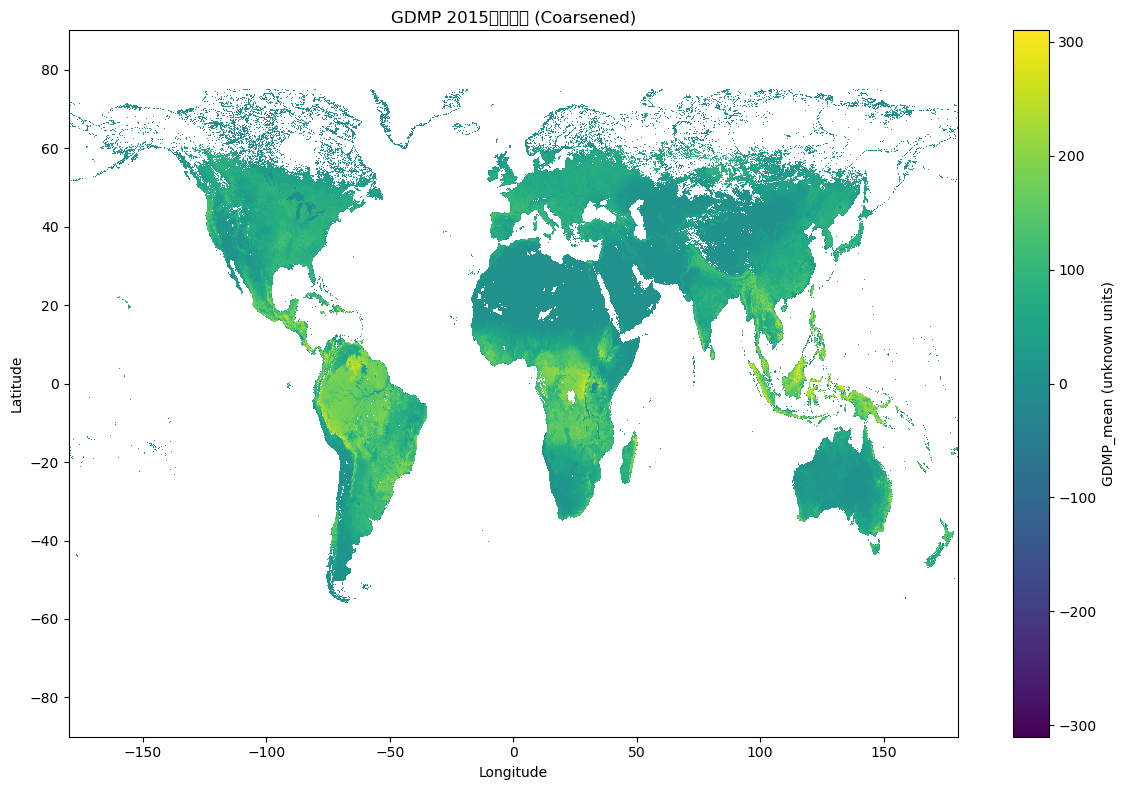


数据基本信息:
变量名: GDMP_mean
数据范围: -0.04 to 319.57
平均值: 62.61
标准差: 59.38


C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  plt.tight_layout()
C:\Users\zpy10\AppData\Local\Temp\ipykernel_8940\1778086851.py:43: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:15

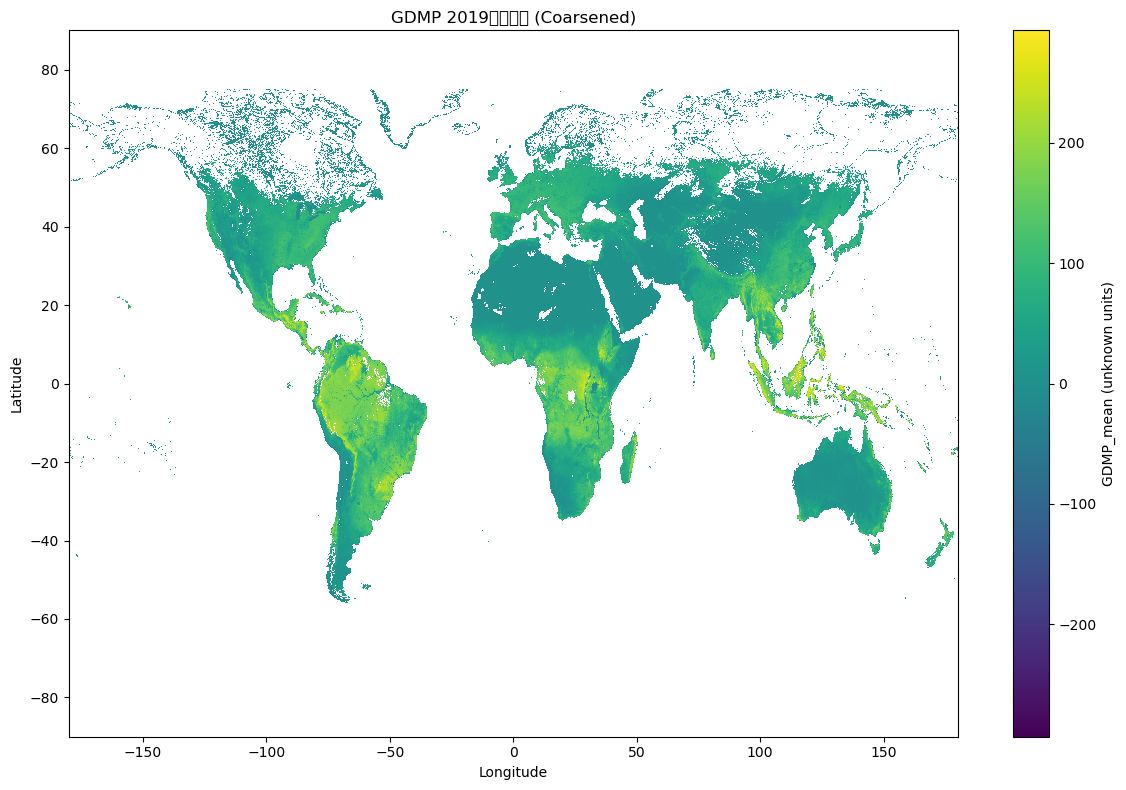


数据基本信息:
变量名: GDMP_mean
数据范围: -0.04 to 305.54
平均值: 61.91
标准差: 57.40


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_data(file_path, title, coarse_factor=10):
    """
    绘制平均值数据，使用coarse方法降低分辨率
    
    Parameters:
    -----------
    file_path : str
        NetCDF文件路径
    title : str
        图表标题
    coarse_factor : int
        降采样因子，值越大图像越粗糙但绘制越快
    """
    # 读取数据集
    ds = xr.open_dataset(file_path)
    
    # 获取变量名（第一个数据变量）
    var_name = list(ds.data_vars)[0]
    data = ds[var_name]
    
    # 使用coarse方法降低分辨率
    coarse_data = data.coarsen(lat=coarse_factor, lon=coarse_factor).mean()
    
    # 创建图形
    plt.figure(figsize=(12, 8))
    
    # 绘制数据
    im = coarse_data.plot(
        cmap='viridis',  # 使用viridis颜色映射
        cbar_kwargs={'label': f'{var_name} ({getattr(data, "units", "unknown units")})'}
    )
    
    # 设置标题和标签
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()
    
    # 打印数据基本信息
    print("\n数据基本信息:")
    print(f"变量名: {var_name}")
    print(f"数据范围: {data.min().values:.2f} to {data.max().values:.2f}")
    print(f"平均值: {data.mean().values:.2f}")
    print(f"标准差: {data.std().values:.2f}")
    
    # 关闭数据集
    ds.close()

# 绘制2015年数据
plot_mean_data(
    r"D:\xarray\aligned\gdmp\mean\gdmp_2015_mean.nc",
    "GDMP 2015年平均值 (Coarsened)",
    coarse_factor=10
)

# 绘制2019年数据
plot_mean_data(
    r"D:\xarray\aligned\gdmp\mean\gdmp_2019_mean.nc",
    "GDMP 2019年平均值 (Coarsened)",
    coarse_factor=10
)

# # 绘制2015年RSDS数据
# plot_mean_data(
#     r"D:\xarray\aligned\rsds\mean\rsds_2015_mean.nc",
#     "RSDS 2015年平均值 (Coarsened)",
#     coarse_factor=10
# )

# # 绘制2019年RSDS数据
# plot_mean_data(
#     r"D:\xarray\aligned\rsds\mean\rsds_2019_mean.nc",
#     "RSDS 2019年平均值 (Coarsened)",
#     coarse_factor=10
# )

### rsdc

In [3]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm
import re
import glob
from dask.diagnostics import ProgressBar

def collect_rsds_files(base_dir, year):
    """收集指定年份的rsds文件路径"""
    pattern = re.compile(f'.*{year}.*\.nc$')
    nc_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.nc') and year in file:
                nc_files.append(os.path.join(root, file))
    
    print(f"收集到{len(nc_files)}个{year}年文件")
    # 打印收集到的文件名称
    for file_path in nc_files:
        print(f"  - {os.path.basename(file_path)}")
    
    return nc_files

def calculate_year_mean(files, output_path, chunk_size={"lat": 540, "lon": 540}):
    """计算多个文件的平均值并保存"""
    if not files:
        print(f"没有文件可处理，跳过计算平均值")
        return
    
    # 打开第一个文件获取变量名
    with xr.open_dataset(files[0]) as ds:
        var_name = list(ds.data_vars)[0]
    
    print(f"使用变量名: {var_name}")
    
    # 累加所有数据并计算平均值
    sum_data = None
    for file in tqdm(files, desc=f"处理 {os.path.basename(output_path).split('.')[0]}"):
        try:
            with xr.open_dataset(file, chunks=chunk_size) as ds:
                if sum_data is None:
                    sum_data = ds[var_name].copy()
                else:
                    sum_data = sum_data + ds[var_name]
        except Exception as e:
            print(f"处理文件 {file} 时出错: {e}")
    
    # 计算平均值
    mean_data = sum_data / len(files)
    
    # 创建新的数据集并保存
    mean_ds = mean_data.to_dataset(name=f"{var_name}_mean")
    
    encoding = {
        f"{var_name}_mean": {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_size["lat"], chunk_size["lon"])
        }
    }
    
    print(f"保存结果到 {output_path}...")
    with ProgressBar():
        mean_ds.to_netcdf(output_path, encoding=encoding)

# 配置路径
base_dir = r"D:\xarray\aligned\rsds"  # 修改为rsds目录
output_dir = r"D:\xarray\aligned\rsds\mean"  # 修改输出目录
os.makedirs(output_dir, exist_ok=True)

# 设置chunk大小为540
optimal_chunks = {"lat": 540, "lon": 540}

# 处理2015年数据
files_2015 = collect_rsds_files(base_dir, "2015")
if files_2015:
    output_2015 = os.path.join(output_dir, "rsds_2015_mean.nc")  # 修改输出文件名
    calculate_year_mean(files_2015, output_2015, optimal_chunks)

# 处理2019年数据
files_2019 = collect_rsds_files(base_dir, "2019")
if files_2019:
    output_2019 = os.path.join(output_dir, "rsds_2019_mean.nc")  # 修改输出文件名
    calculate_year_mean(files_2019, output_2019, optimal_chunks)

print("✅ RSDS年度平均值计算完成")

收集到12个2015年文件
  - CHELSA_rsds_2015_01_V.2.1.nc
  - CHELSA_rsds_2015_02_V.2.1.nc
  - CHELSA_rsds_2015_03_V.2.1.nc
  - CHELSA_rsds_2015_04_V.2.1.nc
  - CHELSA_rsds_2015_05_V.2.1.nc
  - CHELSA_rsds_2015_06_V.2.1.nc
  - CHELSA_rsds_2015_07_V.2.1.nc
  - CHELSA_rsds_2015_08_V.2.1.nc
  - CHELSA_rsds_2015_09_V.2.1.nc
  - CHELSA_rsds_2015_10_V.2.1.nc
  - CHELSA_rsds_2015_11_V.2.1.nc
  - CHELSA_rsds_2015_12_V.2.1.nc
使用变量名: var


处理 rsds_2015_mean: 100%|██████████| 12/12 [00:00<00:00, 16.02it/s]


保存结果到 D:\xarray\aligned\rsds\mean\rsds_2015_mean.nc...
[########################################] | 100% Completed | 305.62 s
收集到12个2019年文件
  - CHELSA_rsds_2019_01_V.2.1.nc
  - CHELSA_rsds_2019_02_V.2.1.nc
  - CHELSA_rsds_2019_03_V.2.1.nc
  - CHELSA_rsds_2019_04_V.2.1.nc
  - CHELSA_rsds_2019_05_V.2.1.nc
  - CHELSA_rsds_2019_06_V.2.1.nc
  - CHELSA_rsds_2019_07_V.2.1.nc
  - CHELSA_rsds_2019_08_V.2.1.nc
  - CHELSA_rsds_2019_09_V.2.1.nc
  - CHELSA_rsds_2019_10_V.2.1.nc
  - CHELSA_rsds_2019_11_V.2.1.nc
  - CHELSA_rsds_2019_12_V.2.1.nc
使用变量名: var


处理 rsds_2019_mean: 100%|██████████| 12/12 [00:00<00:00, 23.56it/s]


保存结果到 D:\xarray\aligned\rsds\mean\rsds_2019_mean.nc...
[########################################] | 100% Completed | 276.42 s
✅ RSDS年度平均值计算完成


### tas

In [4]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm
import re
import glob
from dask.diagnostics import ProgressBar

def collect_tas_files(base_dir, year):
    """收集指定年份的tas文件路径"""
    pattern = re.compile(f'.*{year}.*\.nc$')
    nc_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.nc') and year in file:
                nc_files.append(os.path.join(root, file))
    
    print(f"收集到{len(nc_files)}个{year}年文件")
    # 打印收集到的文件名称
    for file_path in nc_files:
        print(f"  - {os.path.basename(file_path)}")
    
    return nc_files

def calculate_year_mean(files, output_path, chunk_size={"lat": 540, "lon": 540}):
    """计算多个文件的平均值并保存"""
    if not files:
        print(f"没有文件可处理，跳过计算平均值")
        return
    
    # 打开第一个文件获取变量名
    with xr.open_dataset(files[0]) as ds:
        var_name = list(ds.data_vars)[0]
    
    print(f"使用变量名: {var_name}")
    
    # 累加所有数据并计算平均值
    sum_data = None
    for file in tqdm(files, desc=f"处理 {os.path.basename(output_path).split('.')[0]}"):
        try:
            with xr.open_dataset(file, chunks=chunk_size) as ds:
                if sum_data is None:
                    sum_data = ds[var_name].copy()
                else:
                    sum_data = sum_data + ds[var_name]
        except Exception as e:
            print(f"处理文件 {file} 时出错: {e}")
    
    # 计算平均值
    mean_data = sum_data / len(files)
    
    # 创建新的数据集并保存
    mean_ds = mean_data.to_dataset(name=f"{var_name}_mean")
    
    encoding = {
        f"{var_name}_mean": {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_size["lat"], chunk_size["lon"])
        }
    }
    
    print(f"保存结果到 {output_path}...")
    with ProgressBar():
        mean_ds.to_netcdf(output_path, encoding=encoding)

# 配置路径
base_dir = r"D:\xarray\aligned\tas"  # 修改为tas目录
output_dir = r"D:\xarray\aligned\tas\mean"  # 修改输出目录
os.makedirs(output_dir, exist_ok=True)

# 设置chunk大小为540
optimal_chunks = {"lat": 540, "lon": 540}

# 处理2015年数据
files_2015 = collect_tas_files(base_dir, "2015")
if files_2015:
    output_2015 = os.path.join(output_dir, "tas_2015_mean.nc")  # 修改输出文件名
    calculate_year_mean(files_2015, output_2015, optimal_chunks)

# 处理2019年数据
files_2019 = collect_tas_files(base_dir, "2019")
if files_2019:
    output_2019 = os.path.join(output_dir, "tas_2019_mean.nc")  # 修改输出文件名
    calculate_year_mean(files_2019, output_2019, optimal_chunks)

print("✅ TAS年度平均值计算完成")

收集到12个2015年文件
  - CHELSA_tas_01_2015_V.2.1.nc
  - CHELSA_tas_02_2015_V.2.1.nc
  - CHELSA_tas_03_2015_V.2.1.nc
  - CHELSA_tas_04_2015_V.2.1.nc
  - CHELSA_tas_05_2015_V.2.1.nc
  - CHELSA_tas_06_2015_V.2.1.nc
  - CHELSA_tas_07_2015_V.2.1.nc
  - CHELSA_tas_08_2015_V.2.1.nc
  - CHELSA_tas_09_2015_V.2.1.nc
  - CHELSA_tas_10_2015_V.2.1.nc
  - CHELSA_tas_11_2015_V.2.1.nc
  - CHELSA_tas_12_2015_V.2.1.nc
使用变量名: var


处理 tas_2015_mean: 100%|██████████| 12/12 [00:00<00:00, 25.73it/s]


保存结果到 D:\xarray\aligned\tas\mean\tas_2015_mean.nc...
[########################################] | 100% Completed | 465.00 s
收集到12个2019年文件
  - CHELSA_tas_01_2019_V.2.1.nc
  - CHELSA_tas_02_2019_V.2.1.nc
  - CHELSA_tas_03_2019_V.2.1.nc
  - CHELSA_tas_04_2019_V.2.1.nc
  - CHELSA_tas_05_2019_V.2.1.nc
  - CHELSA_tas_06_2019_V.2.1.nc
  - CHELSA_tas_07_2019_V.2.1.nc
  - CHELSA_tas_08_2019_V.2.1.nc
  - CHELSA_tas_09_2019_V.2.1.nc
  - CHELSA_tas_10_2019_V.2.1.nc
  - CHELSA_tas_11_2019_V.2.1.nc
  - CHELSA_tas_12_2019_V.2.1.nc
使用变量名: var


处理 tas_2019_mean: 100%|██████████| 12/12 [00:00<00:00, 28.07it/s]


保存结果到 D:\xarray\aligned\tas\mean\tas_2019_mean.nc...
[########################################] | 100% Completed | 533.20 s
✅ TAS年度平均值计算完成


### wind

In [5]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm
import re
import glob
from dask.diagnostics import ProgressBar

def collect_wind_files(base_dir, year):
    """收集指定年份的wind文件路径"""
    pattern = re.compile(f'.*{year}.*\.nc$')
    nc_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.nc') and year in file:
                nc_files.append(os.path.join(root, file))
    
    print(f"收集到{len(nc_files)}个{year}年文件")
    # 打印收集到的文件名称
    for file_path in nc_files:
        print(f"  - {os.path.basename(file_path)}")
    
    return nc_files

def calculate_year_mean(files, output_path, chunk_size={"lat": 540, "lon": 540}):
    """计算多个文件的平均值并保存"""
    if not files:
        print(f"没有文件可处理，跳过计算平均值")
        return
    
    # 打开第一个文件获取变量名
    with xr.open_dataset(files[0]) as ds:
        var_name = list(ds.data_vars)[0]
    
    print(f"使用变量名: {var_name}")
    
    # 累加所有数据并计算平均值
    sum_data = None
    for file in tqdm(files, desc=f"处理 {os.path.basename(output_path).split('.')[0]}"):
        try:
            with xr.open_dataset(file, chunks=chunk_size) as ds:
                if sum_data is None:
                    sum_data = ds[var_name].copy()
                else:
                    sum_data = sum_data + ds[var_name]
        except Exception as e:
            print(f"处理文件 {file} 时出错: {e}")
    
    # 计算平均值
    mean_data = sum_data / len(files)
    
    # 创建新的数据集并保存
    mean_ds = mean_data.to_dataset(name=f"{var_name}_mean")
    
    encoding = {
        f"{var_name}_mean": {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_size["lat"], chunk_size["lon"])
        }
    }
    
    print(f"保存结果到 {output_path}...")
    with ProgressBar():
        mean_ds.to_netcdf(output_path, encoding=encoding)

# 配置路径
base_dir = r"D:\xarray\aligned\wind"  # 修改为wind目录
output_dir = r"D:\xarray\aligned\wind\mean"  # 修改输出目录
os.makedirs(output_dir, exist_ok=True)

# 设置chunk大小为540
optimal_chunks = {"lat": 540, "lon": 540}

# 处理2015年数据
files_2015 = collect_wind_files(base_dir, "2015")
if files_2015:
    output_2015 = os.path.join(output_dir, "wind_2015_mean.nc")  # 修改输出文件名
    calculate_year_mean(files_2015, output_2015, optimal_chunks)

# 处理2018年数据
files_2018 = collect_wind_files(base_dir, "2018")
if files_2018:
    output_2018 = os.path.join(output_dir, "wind_2018_mean.nc")  # 修改输出文件名
    calculate_year_mean(files_2018, output_2018, optimal_chunks)

print("✅ WIND年度平均值计算完成")

收集到12个2015年文件
  - CHELSA_sfcWind_01_2015_V.2.1.nc
  - CHELSA_sfcWind_02_2015_V.2.1.nc
  - CHELSA_sfcWind_03_2015_V.2.1.nc
  - CHELSA_sfcWind_04_2015_V.2.1.nc
  - CHELSA_sfcWind_05_2015_V.2.1.nc
  - CHELSA_sfcWind_06_2015_V.2.1.nc
  - CHELSA_sfcWind_07_2015_V.2.1.nc
  - CHELSA_sfcWind_08_2015_V.2.1.nc
  - CHELSA_sfcWind_09_2015_V.2.1.nc
  - CHELSA_sfcWind_10_2015_V.2.1.nc
  - CHELSA_sfcWind_11_2015_V.2.1.nc
  - CHELSA_sfcWind_12_2015_V.2.1.nc
使用变量名: var


处理 wind_2015_mean: 100%|██████████| 12/12 [00:00<00:00, 26.79it/s]


保存结果到 D:\xarray\aligned\wind\mean\wind_2015_mean.nc...
[########################################] | 100% Completed | 331.60 s
收集到12个2018年文件
  - CHELSA_sfcWind_01_2018_V.2.1.nc
  - CHELSA_sfcWind_02_2018_V.2.1.nc
  - CHELSA_sfcWind_03_2018_V.2.1.nc
  - CHELSA_sfcWind_04_2018_V.2.1.nc
  - CHELSA_sfcWind_05_2018_V.2.1.nc
  - CHELSA_sfcWind_06_2018_V.2.1.nc
  - CHELSA_sfcWind_07_2018_V.2.1.nc
  - CHELSA_sfcWind_08_2018_V.2.1.nc
  - CHELSA_sfcWind_09_2018_V.2.1.nc
  - CHELSA_sfcWind_10_2018_V.2.1.nc
  - CHELSA_sfcWind_11_2018_V.2.1.nc
  - CHELSA_sfcWind_12_2018_V.2.1.nc
使用变量名: var


处理 wind_2018_mean: 100%|██████████| 12/12 [00:00<00:00, 30.93it/s]


保存结果到 D:\xarray\aligned\wind\mean\wind_2018_mean.nc...
[########################################] | 100% Completed | 304.89 s
✅ WIND年度平均值计算完成


In [1]:
import xarray as xr

# 打开数据集
MASTER_2 = r"D:\xarray\aligned2\master_final.nc"
ds_1 = xr.open_dataset(r"D:\xarray\aligned2\rsds\CHELSA_rsds_2015_01_V.2.1.nc")
FINAL = r"D:\xarray\final_mask_1km_new.nc"
ds_2 = xr.open_dataset(r"D:\xarray\aligned\rsds\CHELSA_rsds_2015_01_V.2.1.nc")

# 打印第一个数据集信息
print("===== ds_1 信息 =====")
print(f"文件路径: D:\\xarray\\aligned2\\rsds\\CHELSA_rsds_2015_01_V.2.1.nc")
print(f"维度: {ds_1.dims}")
print(f"分辨率: {ds_1.rio.resolution() if hasattr(ds_1, 'rio') else '无法获取'}")
print(f"变量列表: {list(ds_1.data_vars)}")
for var in ds_1.data_vars:
    print(f"变量 {var} 类型: {ds_1[var].dtype}")
    print(f"变量 {var} 形状: {ds_1[var].shape}")

# 打印第二个数据集信息
print("\n===== ds_2 信息 =====")
print(f"文件路径: D:\\xarray\\aligned\\rsds\\CHELSA_rsds_2015_01_V.2.1.nc")
print(f"维度: {ds_2.dims}")
print(f"分辨率: {ds_2.rio.resolution() if hasattr(ds_2, 'rio') else '无法获取'}")
print(f"变量列表: {list(ds_2.data_vars)}")
for var in ds_2.data_vars:
    print(f"变量 {var} 类型: {ds_2[var].dtype}")
    print(f"变量 {var} 形状: {ds_2[var].shape}")

# 尝试打开并打印MASTER_2和FINAL的信息
try:
    master_ds = xr.open_dataset(MASTER_2)
    print("\n===== MASTER_2 信息 =====")
    print(f"文件路径: {MASTER_2}")
    print(f"维度: {master_ds.dims}")
    print(f"变量列表: {list(master_ds.data_vars)}")
    for var in master_ds.data_vars:
        print(f"变量 {var} 类型: {master_ds[var].dtype}")
        print(f"变量 {var} 形状: {master_ds[var].shape}")
    master_ds.close()
except Exception as e:
    print(f"\n无法打开MASTER_2文件: {e}")

try:
    final_ds = xr.open_dataset(FINAL)
    print("\n===== FINAL 信息 =====")
    print(f"文件路径: {FINAL}")
    print(f"维度: {final_ds.dims}")
    print(f"变量列表: {list(final_ds.data_vars)}")
    for var in final_ds.data_vars:
        print(f"变量 {var} 类型: {final_ds[var].dtype}")
        print(f"变量 {var} 形状: {final_ds[var].shape}")
    final_ds.close()
except Exception as e:
    print(f"\n无法打开FINAL文件: {e}")


===== ds_1 信息 =====
文件路径: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_01_V.2.1.nc
维度: FrozenMappingWarningOnValuesAccess({'lon': 43200, 'lat': 21600})
分辨率: (0.0083333333, -0.0083333333)
变量列表: ['var']
变量 var 类型: float32
变量 var 形状: (21600, 43200)

===== ds_2 信息 =====
文件路径: D:\xarray\aligned\rsds\CHELSA_rsds_2015_01_V.2.1.nc
维度: FrozenMappingWarningOnValuesAccess({'lon': 43200, 'lat': 21600})
分辨率: (0.0083333333, -0.0083333333)
变量列表: ['var']
变量 var 类型: float32
变量 var 形状: (21600, 43200)

===== MASTER_2 信息 =====
文件路径: D:\xarray\aligned2\master_final.nc
维度: FrozenMappingWarningOnValuesAccess({'lon': 43200, 'lat': 21600})
变量列表: ['land_mask']
变量 land_mask 类型: uint8
变量 land_mask 形状: (21600, 43200)

===== FINAL 信息 =====
文件路径: D:\xarray\final_mask_1km_new.nc
维度: FrozenMappingWarningOnValuesAccess({'lat': 21600, 'lon': 43200})
变量列表: ['final_mask']
变量 final_mask 类型: float32
变量 final_mask 形状: (21600, 43200)
